# 1.初步处理

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [164]:
data = pd.read_csv('add1.csv')

data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X16,X17,X18,X19,X20,X21,X22,X23,X24,"Y(1=default, 0=non-default)"
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,12,2,17,1,4,2,4,1,31,...,0,0,1,0,0,1,0,1,0,0
996,1,30,2,39,1,3,1,4,2,40,...,0,1,1,0,0,1,0,0,0,0
997,4,12,2,8,1,5,3,4,3,38,...,0,0,1,0,0,1,0,0,1,0
998,1,45,2,18,1,3,3,4,4,23,...,0,0,1,0,0,0,0,0,1,1


# 2.信息价值计算

## 2.1 对特定特征划分区间，计算IV

In [158]:
# 定义划分区间的函数
def binning_feature(data, feature):
    # 基于分布进行等频分箱
    bins = np.quantile(data[feature].dropna(), [0, 0.2, 0.4, 0.6, 0.8, 1])
    # 分箱，将分箱结果作为新的列添加
    binned_feature = pd.cut(data[feature], bins, labels=False, duplicates='drop')
    return binned_feature

# 定义计算IV的函数
def calculate_iv(data, feature, target):
    total_bad = data[target].sum()
    total_good = data[target].count() - total_bad
    grouped = data.groupby(feature)[target].agg(['sum', 'count'])
    grouped.columns = ['bad', 'total']
    grouped['good'] = grouped['total'] - grouped['bad']

    # 避免分母为零的情况
    grouped['Bi'] = np.where(grouped['bad'] == 0, 0.00001, grouped['bad'] / total_bad)
    grouped['Gi'] = np.where(grouped['good'] == 0, 0.00001, grouped['good'] / total_good)

    grouped['WOE'] = np.log(grouped['Bi'] / grouped['Gi'])
    grouped['IV'] = (grouped['Bi'] - grouped['Gi']) * grouped['WOE']

    feature_iv = grouped['IV'].sum()
    return feature_iv

# 为特定的连续特征划分区间
for feature in ['X2', 'X4', 'X10']:
    data[feature] = binning_feature(data, feature)

# 计算所有特征的IV值
iv_results = {}
for col in data.columns:
    if col != 'Y(1=default, 0=non-default)': 
        iv_results[col] = calculate_iv(data, col, 'Y(1=default, 0=non-default)')

iv_df = pd.DataFrame.from_dict(iv_results, orient='index', columns=['IV Value'])
iv_df.to_csv('IV值2.csv', index=True)

iv_df

,IV Value
X1,0.666012
X2,0.209125
X3,0.293234
X4,0.089321
X5,0.196010
X6,0.086434
X7,0.044671
X8,0.003589
X9,0.112638
X10,0.067201


## 2.2 绘制IV图

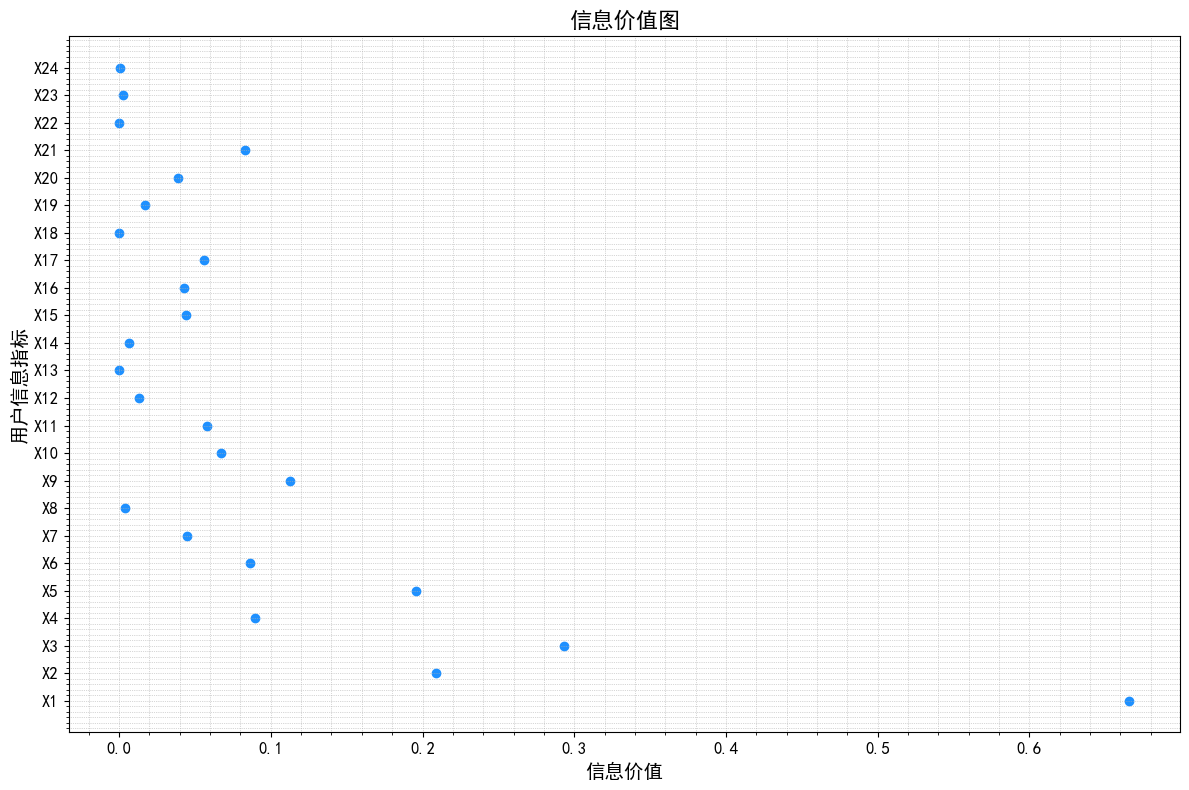

In [159]:
# 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 8))
plt.scatter(iv_df['IV Value'], iv_df.index, color='dodgerblue')
plt.title('信息价值图', fontsize=16)
plt.xlabel('信息价值', fontsize=14)
plt.ylabel('用户信息指标', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(which='both', linestyle=':', linewidth=0.5)
plt.minorticks_on()
plt.tight_layout()

plt.savefig('IV值.png')
plt.show()

## 2.3 根据IV值筛选特征

In [160]:
def categorize_iv(value):
    if value < 0.02:
        return '无用特征'
    elif 0.02 <= value < 0.1:
        return '弱价值特征'
    elif 0.1 <= value < 0.3:
        return '中价值特征'
    elif 0.3 <= value < 0.5:
        return '强价值特征'
    else:
        return '价值过高，不真实'

# 存储标签
iv_df['价值分类'] = iv_df['IV Value'].apply(categorize_iv)

# 筛选出需要的数据
filtered_iv_df = iv_df[iv_df['价值分类'].isin(['中价值特征', '强价值特征'])]

filtered_data_path = '筛选1.csv'
filtered_iv_df.to_csv(filtered_data_path, index=True)

filtered_iv_df

,IV Value,价值分类
X2,0.209125,中价值特征
X3,0.293234,中价值特征
X5,0.196010,中价值特征
X9,0.112638,中价值特征


In [165]:
#从源文件中提取筛选后的数据
selected_features = [
    'X2', 'X3', 'X5', 'X9', 'Y(1=default, 0=non-default)'
]
filtered_data = data[selected_features]

output_path = '筛选add1.csv'
filtered_data.to_csv(output_path, index=False)

filtered_data

,X2,X3,X5,X9,"Y(1=default, 0=non-default)"
0,6,4,5,1,0
1,48,2,1,1,1
2,12,4,1,1,0
3,42,2,1,2,0
4,24,3,1,4,1
...,...,...,...,...,...
995,12,2,1,1,0
996,30,2,1,2,0
997,12,2,1,3,0
998,45,2,1,4,1


# 3.一致性比率计算

In [166]:
data_path = '筛选add1.csv'
filtered_data = pd.read_csv(data_path)

# 对分箱
bins = np.quantile(filtered_data['X2'].dropna(), [0, 0.2, 0.4, 0.6, 0.8, 1])
filtered_data.loc[:, 'X2_binned'] = pd.cut(filtered_data['X2'], bins, labels=[0, 1, 2, 3, 4], include_lowest=True)

# 定义一致性比率计算函数
def consistency_ratio(filtered_data, features, target):
    # 根据特征子集创建组合键
    filtered_data = filtered_data.copy()
    filtered_data.loc[:, 'group_key'] = filtered_data[features].apply(lambda x: tuple(x), axis=1)
    # 对组合键进行分组，并计算每组的违约和非违约样本数量
    group_counts = filtered_data.groupby('group_key')[target].agg(['sum', 'count'])
    group_counts['non_defaults'] = group_counts['count'] - group_counts['sum']  # 非违约
    group_counts['defaults'] = group_counts['sum']  # 违约
    
    # 计算一致性比率，考虑每组中较大类别的样本数量
    max_class_sum = group_counts[['non_defaults', 'defaults']].max(axis=1).sum()
    cs = max_class_sum / len(filtered_data)
    return cs

# 计算
cs_value = consistency_ratio(filtered_data, ['X2_binned', 'X3', 'X5', 'X9'], 'Y(1=default, 0=non-default)')
print(f"一致性比率: {cr_value}")

一致性比率: 0.785
